In [1]:
import pandas as pd
import os
import re
import numpy as np
from merf import MERF
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
sns.set_context("poster")
from sklearn.ensemble import RandomForestRegressor
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
from merf.viz import plot_merf_training_stats
from em_utils import *

This code is using MERF, with parameters selected from fine tunining in a seperate script. 

In [2]:
# Create output directory if it doesn't exist
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_plots/1.clinical"
df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/merf_dfs/"
os.makedirs(output_dir, exist_ok=True)

print("---------- Read metadata ----------")
m1_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/data/clinical/transformed/aim2"
test = read_data(m1_dir, "a2_test_samples_standard_clinical.csv")
train = read_data(m1_dir, "a2_train_samples_standard_clinical.csv")
full = read_data(m1_dir, "a2_meta_Transformed_standard_clinical.csv")
full_raw = read_data(m1_dir, "a2_meta_not_Transformed_standard_clinical.csv")

# Apply the function to each meta dataset
print("---------- Convert metadata to long format ----------")
full_long = make_long(full_raw)
full_long['x_t'] = full_long['subject_id'].astype(str) + '.' + full_long['time'].astype(str)

train_long = make_long(train)
train_long['x_t'] = train_long['subject_id'].astype(str) + '.' + train_long['time'].astype(str)

test_long = make_long(test)
test_long['x_t'] = test_long['subject_id'].astype(str) + '.' + test_long['time'].astype(str)

# Drop cols
columns_to_drop = ['Unnamed: 0', 'cohort_number', 'record_id', 'x_t']
full_long = full_long.drop([col for col in columns_to_drop if col in full.columns], axis=1)
train_long = train_long.drop([col for col in columns_to_drop if col in train_long.columns], axis=1)
test_long = test_long.drop([col for col in columns_to_drop if col in test_long.columns], axis=1)

# Drop NA 
test_long = test_long.dropna()
train_long = train_long.dropna()
full_long = full_long.dropna()
raw_train = full_long[full_long['subject_id'].isin(train_long['subject_id'])]
raw_test = full_long[full_long['subject_id'].isin(test_long['subject_id'])]

---------- Read metadata ----------
---------- Convert metadata to long format ----------


### Create test and training sets 

In [3]:
print("---------- Select predictors for Basic Raw training set ----------")
train_set = raw_train
X = train_set.drop(['outcome_BMI_fnl', 'subject_id'], axis=1)
#X = X.drop(columns=['Unnamed: 0_tax', 'x_t'], errors='ignore')
Y = train_set[['outcome_BMI_fnl']]
Y = Y['outcome_BMI_fnl'].to_numpy() # Convert Y to numeric array
clusters_train = train_set['subject_id'].to_numpy() # Get ID variables
Z = np.ones((train_set.shape[0], 1)) # Create random effects matrix with ones
time = train_set['time'].astype(float).to_numpy() # Get time values as numeric array 

# Check the final columns
print("Final columns after drop:", X.columns.to_list())
print("X train values:", train_set['outcome_BMI_fnl'])

print("---------- Select predictors for Basic Raw test set ----------")
test_set = raw_test
X_new = test_set.drop(['outcome_BMI_fnl', 'subject_id'], axis=1)
X_new = X_new[X.columns]  # Reorder and select columns to match training set
X_new = X_new.astype(X.dtypes)  # Ensure data types match
Y_new = test_set['outcome_BMI_fnl'].to_numpy()  # Convert Y to numeric array
clusters_new = pd.Series(test_set['subject_id'])  # Convert to pandas Series
# Create random effects matrix with ones
Z_new = np.ones((len(X_new), 1))
time_new = test_set['time'].astype(float).to_numpy()  # Convert time values to numeric array

---------- Select predictors for Basic Raw training set ----------
Final columns after drop: ['randomized_group', 'sex', 'race', 'age', 'time', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid', 'x_t']
X train values: 0      33.797697
1      24.081263
2      22.951445
9      34.697265
10     32.047474
         ...    
356    34.171185
357    35.675257
358    33.249710
359    28.354304
360    26.304091
Name: outcome_BMI_fnl, Length: 275, dtype: float64
---------- Select predictors for Basic Raw test set ----------


In [4]:
# set thresholds
best_mse_param_grid = {
    'n_estimators': [100],
    'max_depth': [50],
    'min_samples_split': [5],
    'max_iter': [10]
}

highest_prev_param_grid = {
    'n_estimators': [300],
    'max_depth': [100],
    'min_samples_split': [5],
    'max_iter': [10]
}

highest_ptev_param_grid = {
    'n_estimators': [100],
    'max_depth': [100],
    'min_samples_split': [2],
    'max_iter': [10]
}

tuned_param_grid = {
    'n_estimators': [300],
    'max_depth': [None],
    'min_samples_split': [2],
    'max_iter': [100]
}

mse_mrf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = best_mse_param_grid['n_estimators'][0], 
                                max_depth = best_mse_param_grid['max_depth'][0], 
                                min_samples_split = best_mse_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = best_mse_param_grid['max_iter'][0])

prev_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = highest_prev_param_grid['n_estimators'][0], 
                                max_depth = highest_prev_param_grid['max_depth'][0], 
                                min_samples_split = highest_prev_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = highest_prev_param_grid['max_iter'][0])

ptev_merf = MERF(fixed_effects_model =
           RandomForestRegressor(n_estimators = highest_ptev_param_grid['n_estimators'][0], 
                                max_depth = highest_ptev_param_grid['max_depth'][0], 
                                min_samples_split = highest_ptev_param_grid['min_samples_split'][0], 
                                n_jobs = 1, 
                                oob_score= True),
            gll_early_stop_threshold=None,
            max_iterations = highest_ptev_param_grid['max_iter'][0])

tuned_model = MERF(fixed_effects_model=RandomForestRegressor(
                    n_estimators= tuned_param_grid['n_estimators'][0],  # Number of trees in the forest
                    max_depth= tuned_param_grid['max_depth'][0],  # Maximum depth of each tree
                    min_samples_split= tuned_param_grid['min_samples_split'][0],  # Minimum samples required to split an internal node
                    n_jobs=1,  # Number of jobs to run in parallel
                    oob_score=True),  # Whether to use out-of-bag samples to estimate the R^2 on unseen data
                gll_early_stop_threshold=None,  # No early stopping threshold set
                max_iterations= tuned_param_grid['max_iter'][0])  # Maximum number of iterations to run the MERF algorithm

print("---------- RUN MERF RAW BASIC🌱 ----------")
mrf_mse = mse_mrf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_prev = prev_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

mrf_ptev = ptev_merf.fit(X.select_dtypes(include=[np.number]), 
        Z, 
        pd.Series(clusters_train), 
        Y)

tuned_model = tuned_model.fit(X.select_dtypes(include=[np.number]), 
                Z, 
                pd.Series(clusters_train), 
                Y)

INFO     [merf.py:307] Training GLL is 356.89024821519547 at iteration 1.


---------- RUN MERF RAW BASIC🌱 ----------


INFO     [merf.py:307] Training GLL is 393.78877156919117 at iteration 2.
INFO     [merf.py:307] Training GLL is 369.30556796323265 at iteration 3.
INFO     [merf.py:307] Training GLL is 358.2690031177253 at iteration 4.
INFO     [merf.py:307] Training GLL is 349.22642702968693 at iteration 5.
INFO     [merf.py:307] Training GLL is 326.059121346934 at iteration 6.
INFO     [merf.py:307] Training GLL is 330.037554356202 at iteration 7.
INFO     [merf.py:307] Training GLL is 312.3693693715963 at iteration 8.
INFO     [merf.py:307] Training GLL is 300.0076969808032 at iteration 9.
INFO     [merf.py:307] Training GLL is 289.1156136972496 at iteration 10.
INFO     [merf.py:307] Training GLL is 325.12533493563774 at iteration 1.
INFO     [merf.py:307] Training GLL is 380.8505473587603 at iteration 2.
INFO     [merf.py:307] Training GLL is 366.058778771012 at iteration 3.
INFO     [merf.py:307] Training GLL is 343.87330506805733 at iteration 4.
INFO     [merf.py:307] Training GLL is 332.69090

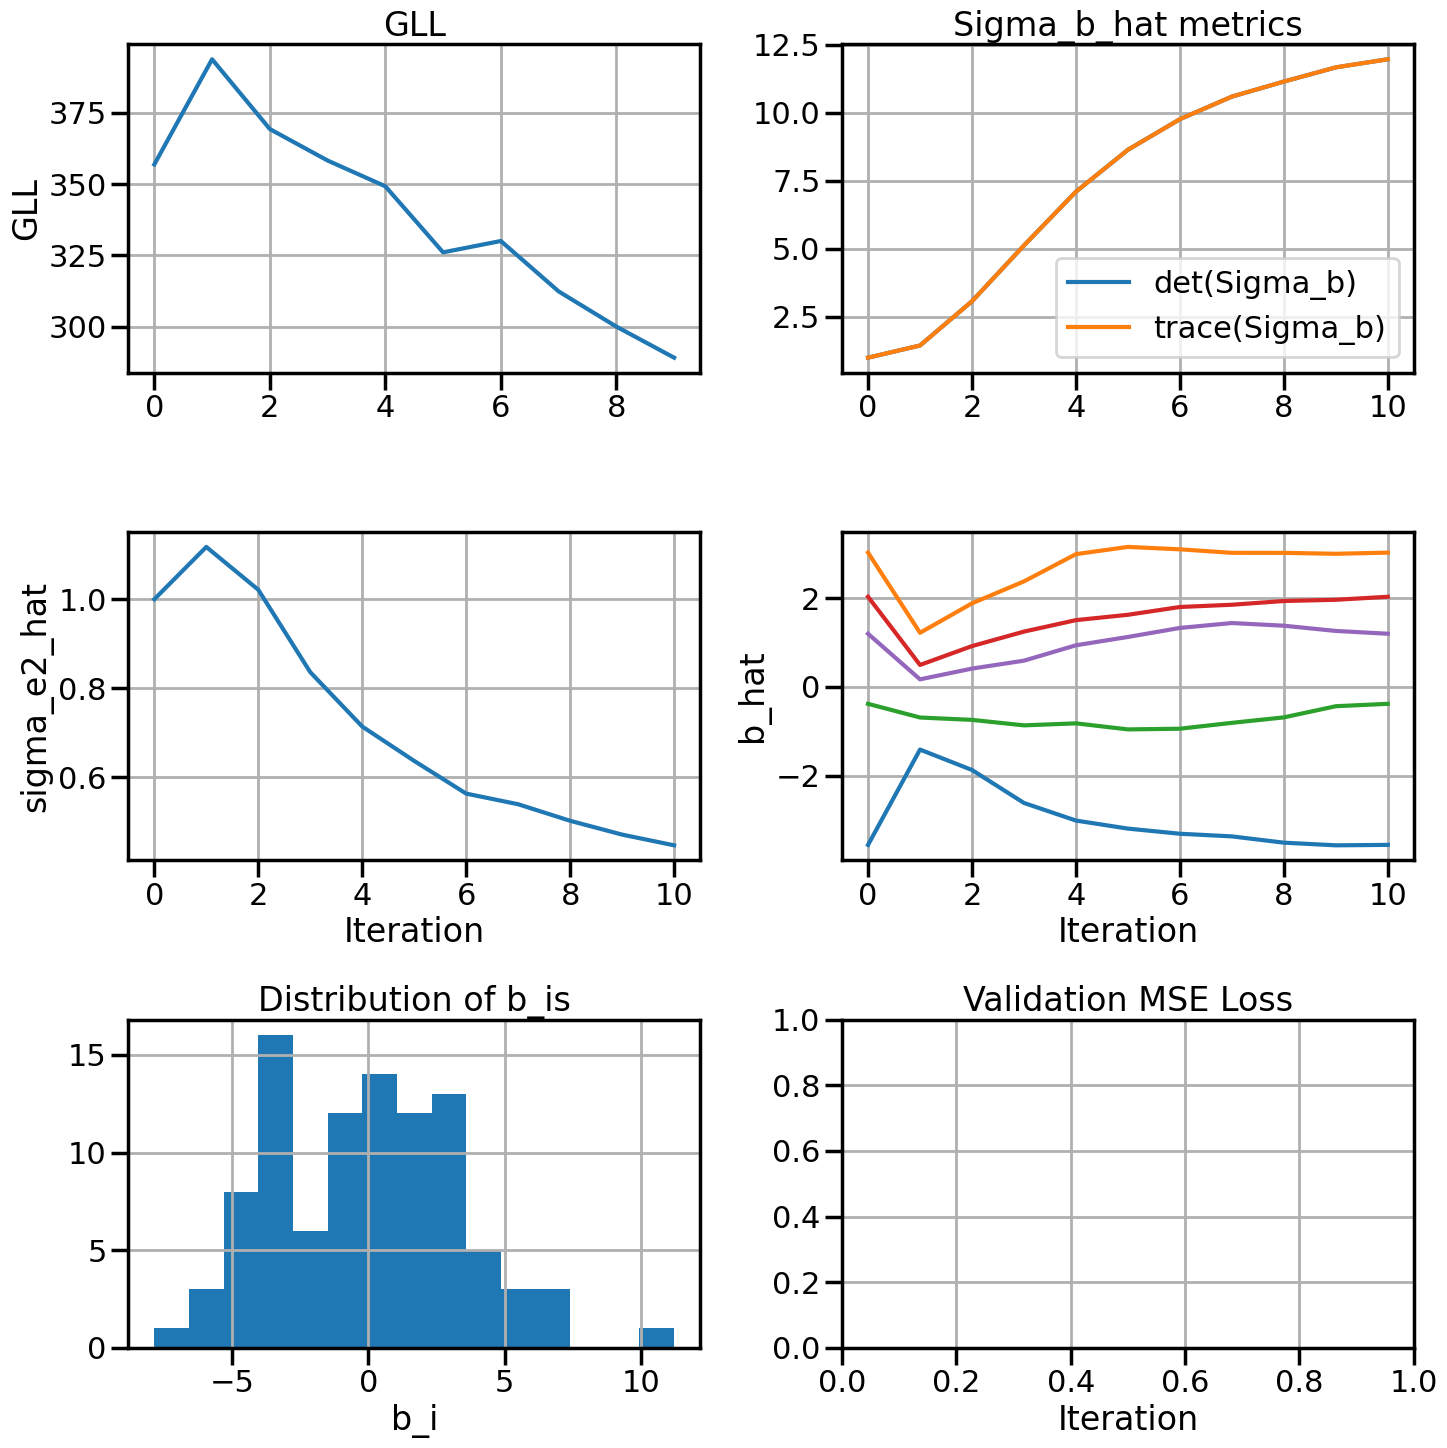

In [5]:
plot_merf_training_stats(mrf_mse)
plt.savefig(os.path.join(output_dir, 'tuned_mse_merf_raw_metrics_clinical.png'), dpi=300, bbox_inches='tight')

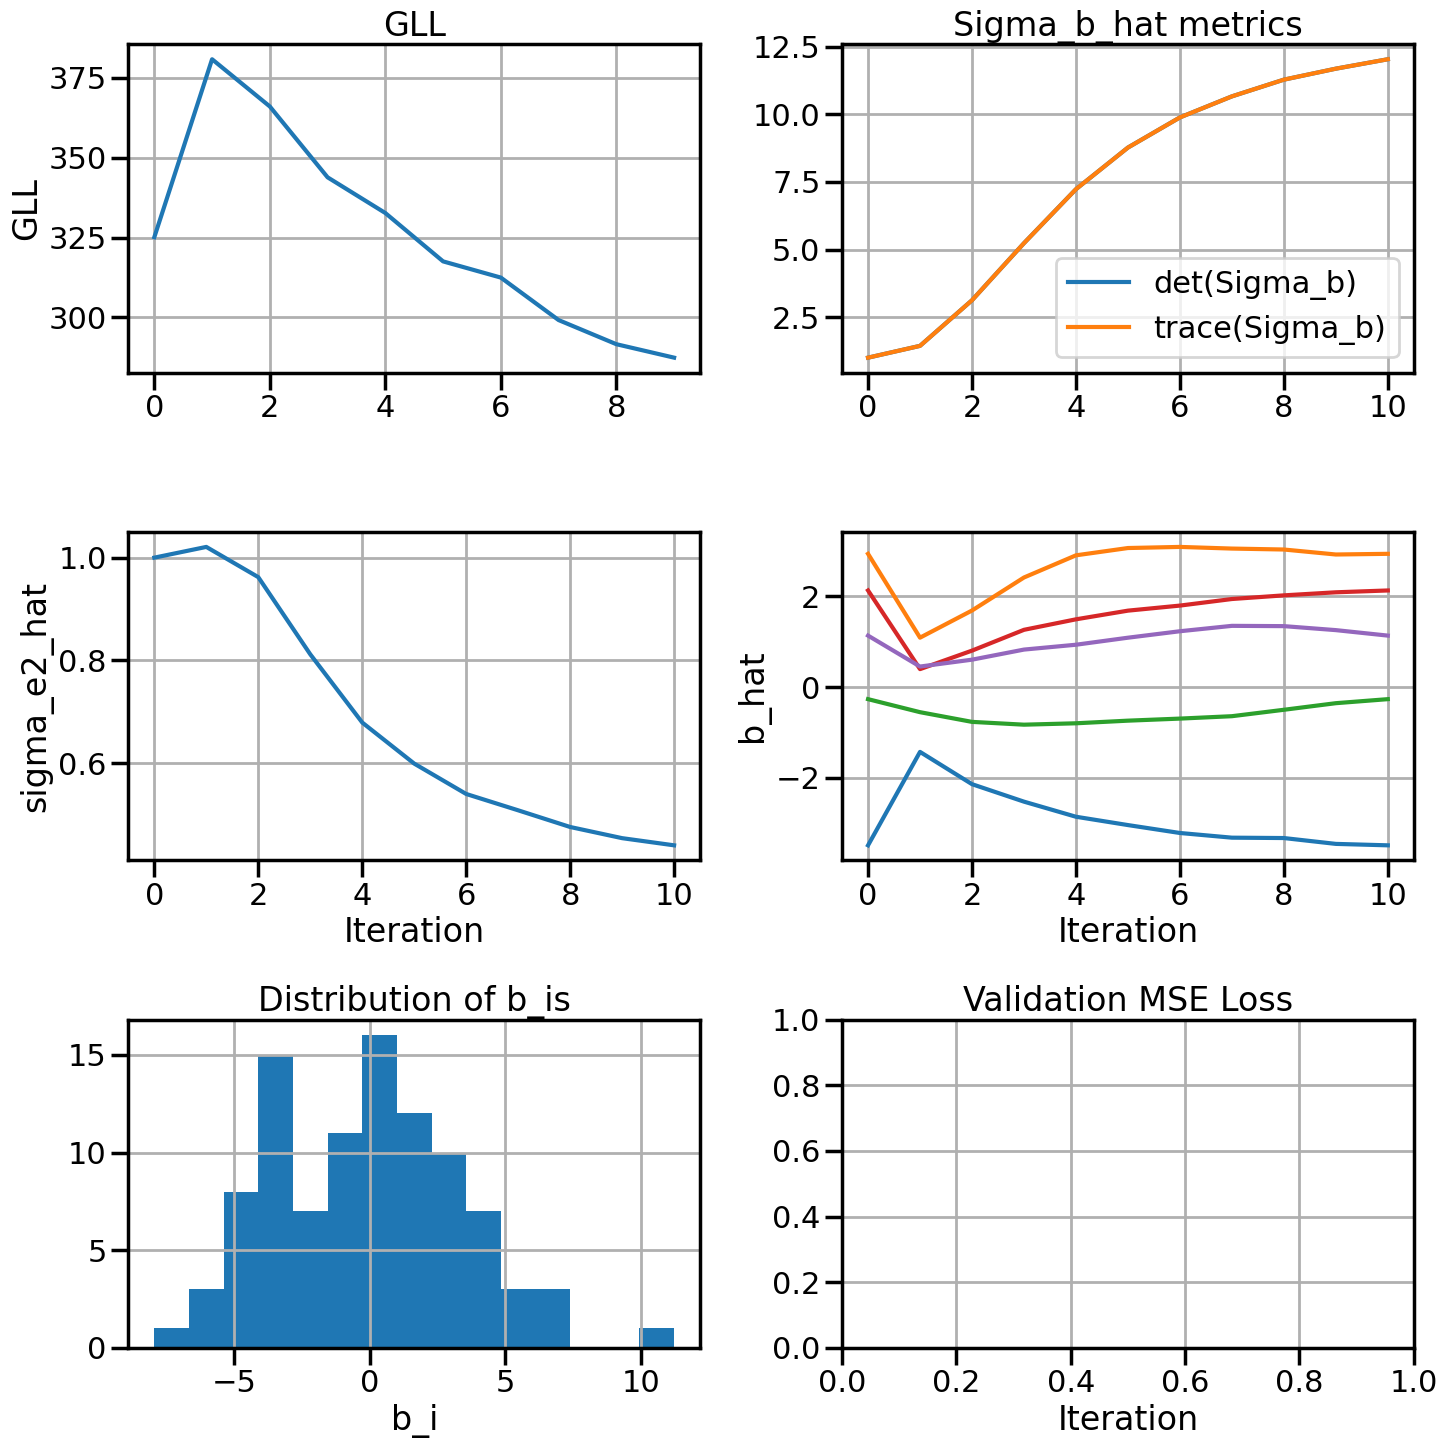

In [6]:
plot_merf_training_stats(mrf_prev)
plt.savefig(os.path.join(output_dir, 'tuned_prev_merf_raw_metrics_clinical.png'), dpi=300, bbox_inches='tight')

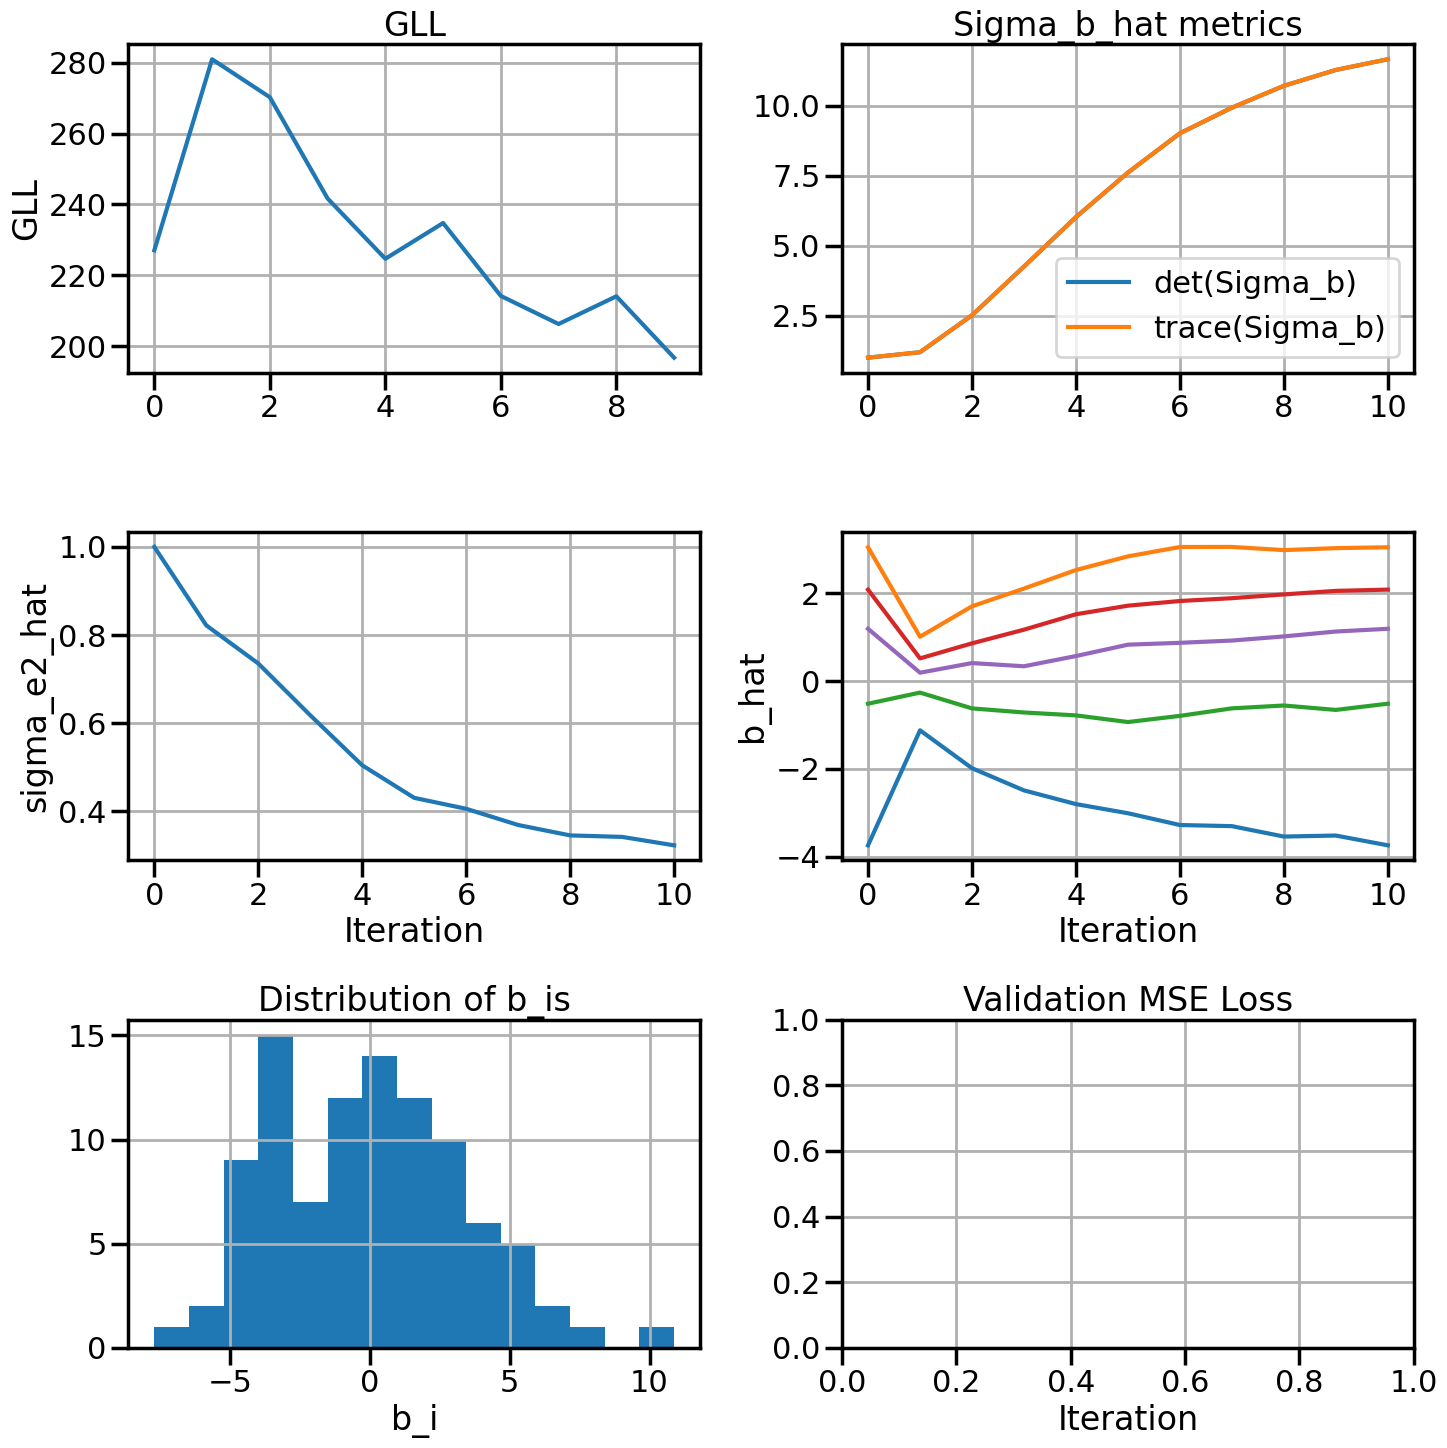

In [7]:
plot_merf_training_stats(mrf_ptev)
plt.savefig(os.path.join(output_dir, 'tuned_ptev_merf_raw_metrics_clinical.png'), dpi=300, bbox_inches='tight')

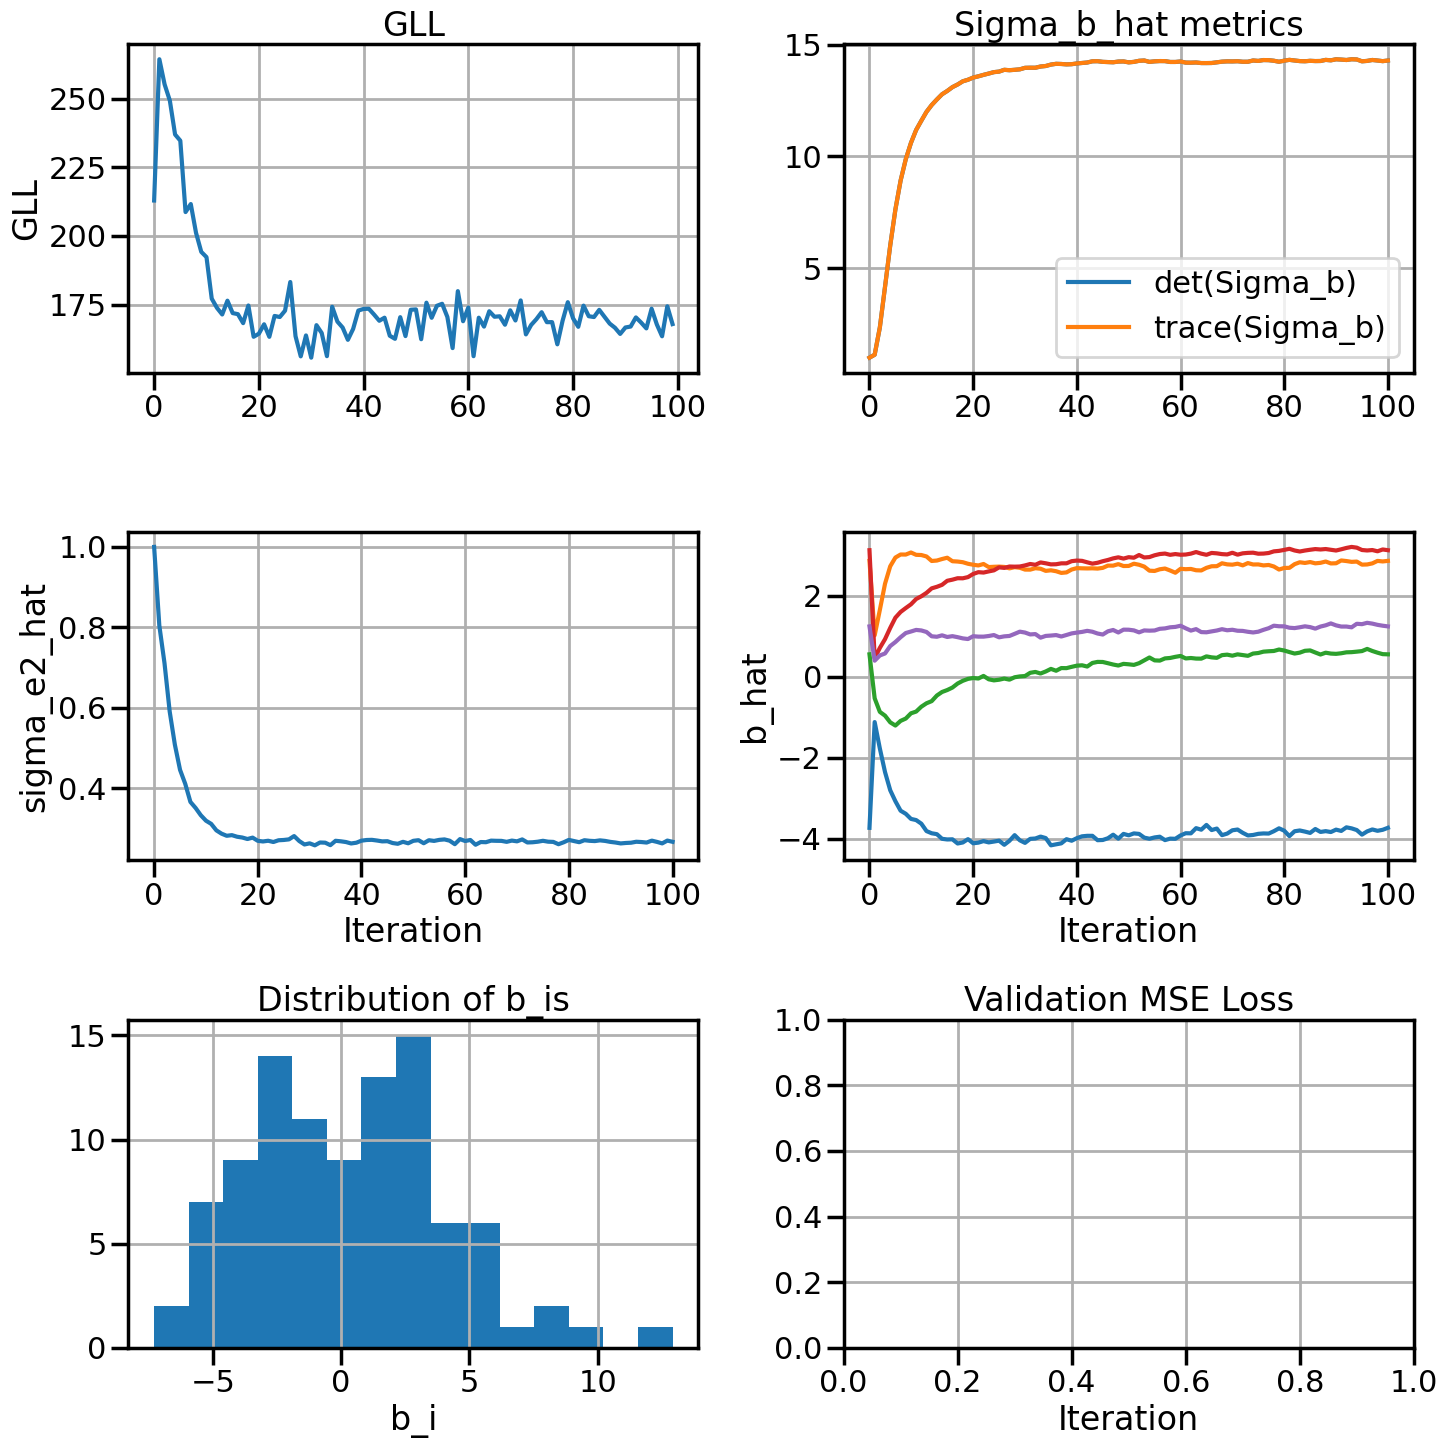

In [8]:
plot_merf_training_stats(tuned_model)
plt.savefig(os.path.join(output_dir, 'tuned_merf_raw_metrics_clinical.png'), dpi=300, bbox_inches='tight')

## Now use tuned parameters for predictions on seperate test sets 

In [9]:
# Predict using the fitted model
X_new = X_new.drop(columns=['x_t'], errors='ignore')
y_hat_new_mse = mrf_mse.predict(X_new, Z_new, clusters_new)
y_hat_new_prev = mrf_prev.predict(X_new, Z_new, clusters_new)
y_hat_new_ptev = mrf_ptev.predict(X_new, Z_new, clusters_new)
y_hat_new_tuned = tuned_model.predict(X_new, Z_new, clusters_new)

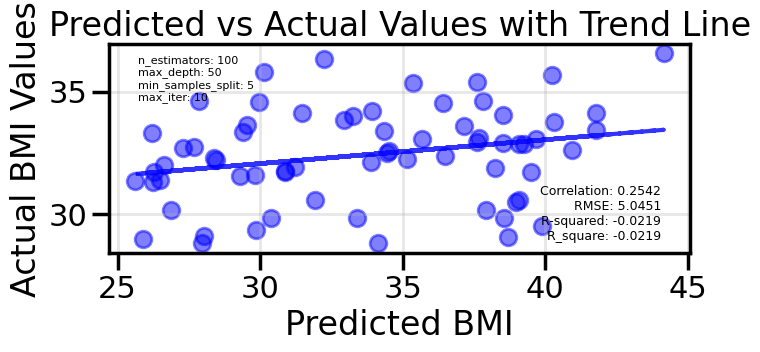

In [10]:
plot_predicted_vs_actual(Y_new, y_hat_new_mse, output_dir, 'clinical_predicted_vs_actual_mse_tuned.png', best_mse_param_grid)

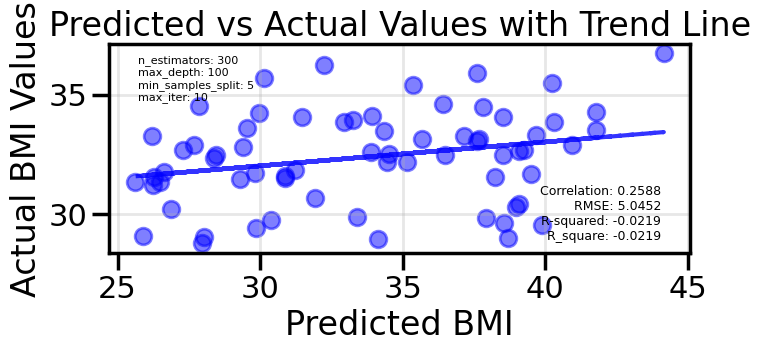

In [11]:
plot_predicted_vs_actual(Y_new, y_hat_new_prev, output_dir, 'clinical_predicted_vs_actual_highest_prev_tuned.png', highest_prev_param_grid)

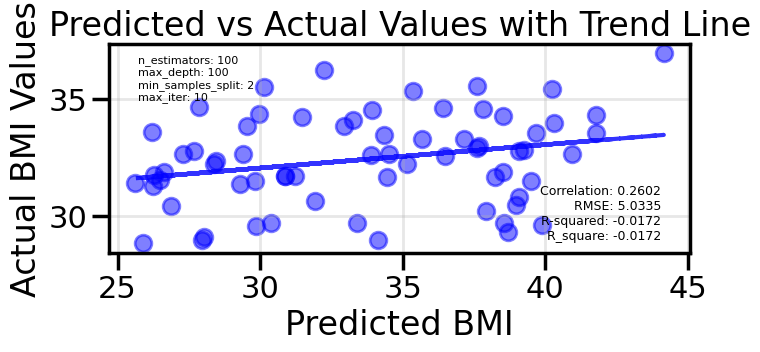

In [12]:
plot_predicted_vs_actual(Y_new, y_hat_new_ptev, output_dir, 'clinical_predicted_vs_actual_highest_ptev_tuned.png', highest_ptev_param_grid)

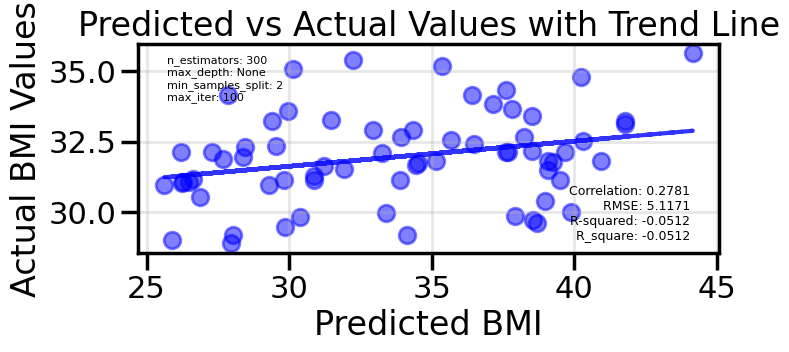

In [13]:
plot_predicted_vs_actual(Y_new, y_hat_new_tuned, output_dir, 'clinical_predicted_vs_actual_tuned.png', tuned_param_grid)

## Look at feature Importances 

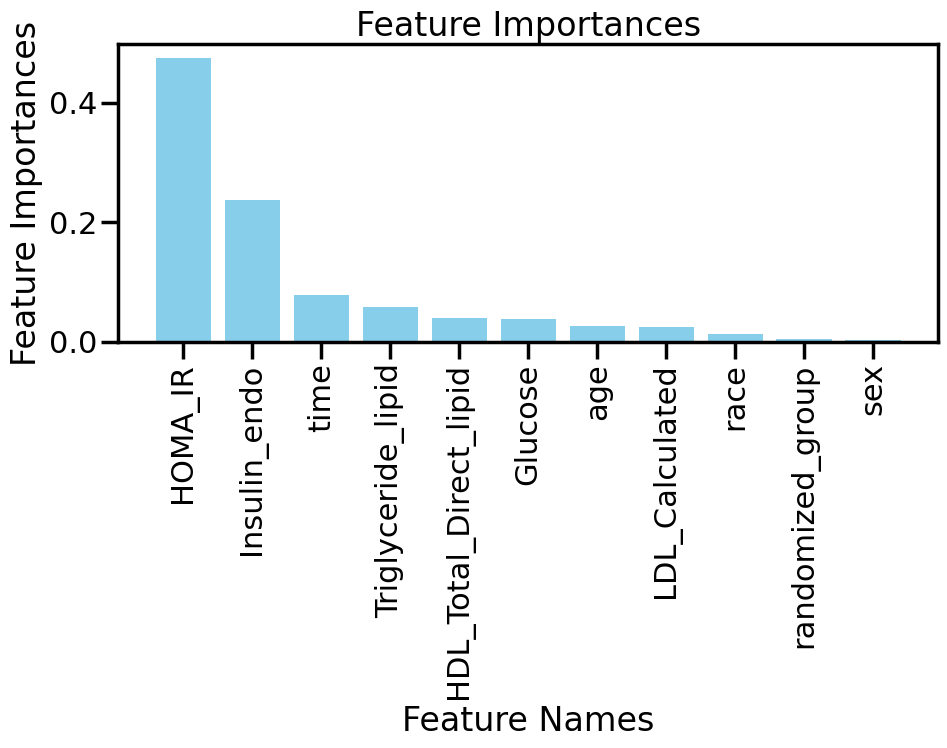

In [14]:
# mse
mse_forest = mrf_mse.trained_fe_model
mse_feature_names = mse_forest.feature_names_in_
mse_feature_importances = mse_forest.feature_importances_
plot_feature_importances(mse_feature_names, mse_feature_importances, 
                         output_dir, 'mse_feature_importances_clinical')

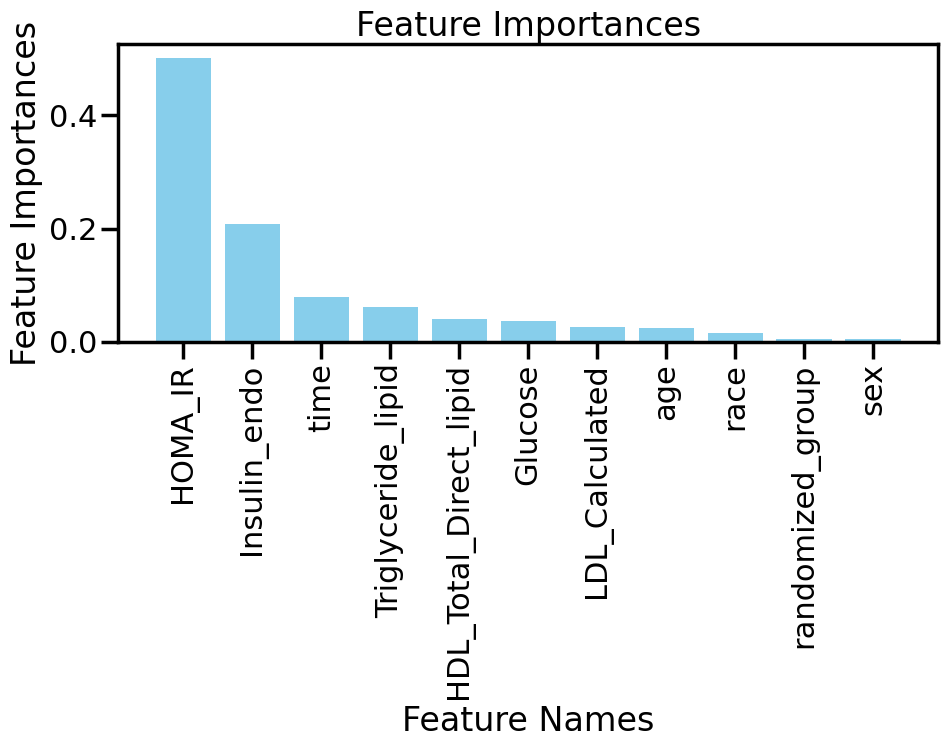

In [15]:
# prev
prev_forest = prev_merf.trained_fe_model
prev_feature_names = prev_forest.feature_names_in_
prev_feature_importances = prev_forest.feature_importances_
plot_feature_importances(prev_feature_names, prev_feature_importances, 
                         output_dir, 'prev_feature_importances_clinical')

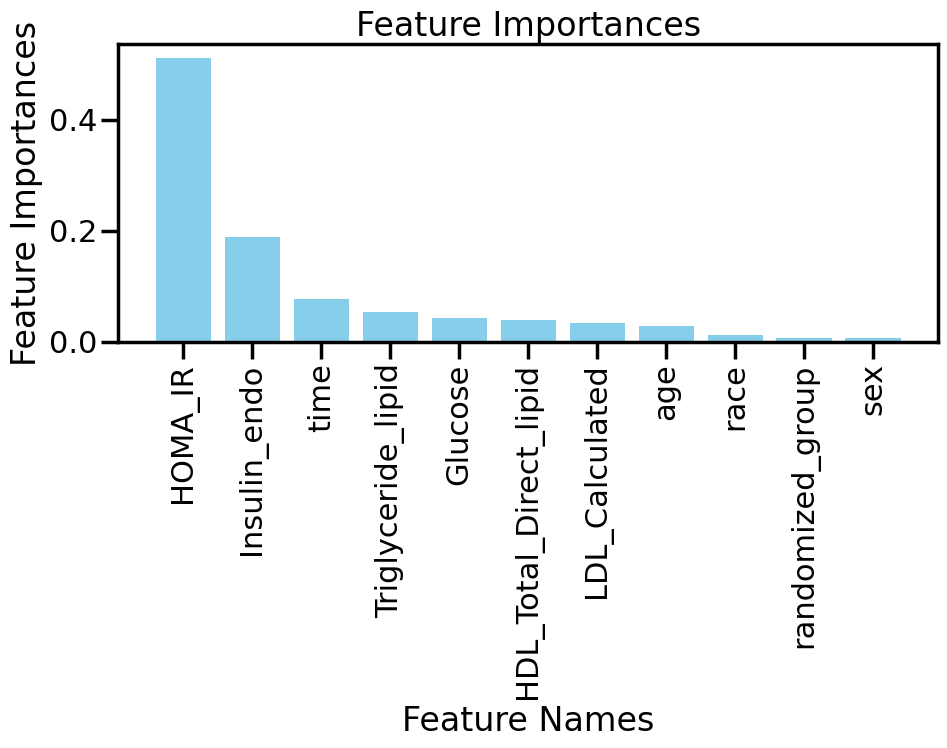

In [16]:
# prev
ptev_forest = ptev_merf.trained_fe_model
ptev_feature_names = ptev_forest.feature_names_in_
ptev_feature_importances = ptev_forest.feature_importances_
plot_feature_importances(ptev_feature_names, ptev_feature_importances, 
                         output_dir, 'ptev_feature_importances_clinical')

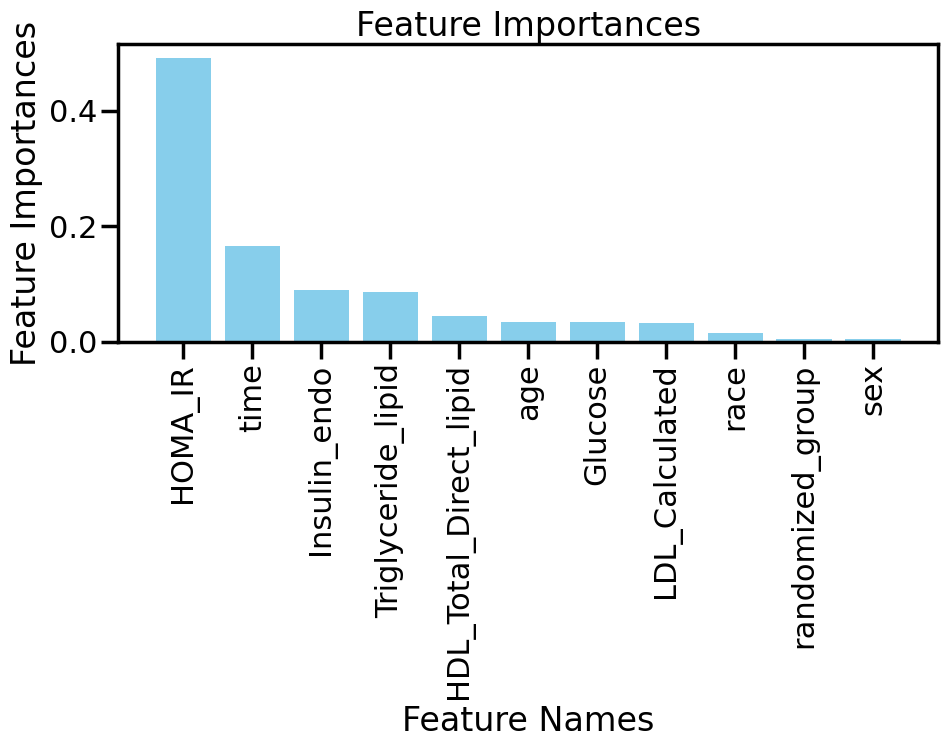

In [17]:

# Tuned
forest = tuned_model.trained_fe_model
feature_names = forest.feature_names_in_
feature_importances = forest.feature_importances_
plot_feature_importances(feature_names, feature_importances, output_dir, 'tuned_feature_importances_clinical')